In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Load enriched data (already cleaned and feature engineered)
df = pd.read_csv('/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/cleaned/Cleaned_IRELAND.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Define feature columns
features = ['Close', 'MA_5', 'MA_20', 'Vol_10', 'RSI_14', 'MACD', 'Signal']

# Drop NaNs and prepare data
df.dropna(inplace=True)
X_raw = df[features].copy()
y_raw = df['Target'].copy()

In [3]:
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_raw)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_raw.values.reshape(-1, 1))

In [4]:
def create_windows(X, y, window_size=60):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_tensor, y_tensor = create_windows(X_scaled, y_scaled.flatten())

In [5]:
def split_data(X, y, train_ratio=0.8):
    split = int(len(X) * train_ratio)
    return X[:split], X[split:], y[:split], y[split:]

X_train, X_test, y_train, y_test = split_data(X_tensor, y_tensor)

In [6]:
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_shape = X_train.shape[1:]
model = build_cnn_lstm_model(input_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
36/36 [==============================] - 2s 14ms/step - loss: 0.0321 - mae: 0.1281 - val_loss: 0.0170 - val_mae: 0.1190
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0052 - mae: 0.0568 - val_loss: 0.0047 - val_mae: 0.0535
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0037 - mae: 0.0479 - val_loss: 0.0020 - val_mae: 0.0320
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0432 - val_loss: 0.0018 - val_mae: 0.0305
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0025 - mae: 0.0396 - val_loss: 0.0036 - val_mae: 0.0494
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0026 - mae: 0.0402 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0025 - mae: 0.0388 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0023 - 

In [7]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

9/9 [==============================] - 0s 2ms/step
Test RMSE: 247.55
Test MAE: 189.38


In [11]:
# -----------------------------------------------
# Step 7: Export for Power BI
# -----------------------------------------------
test_dates = df.index[-len(y_true):]

results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close': y_true.flatten(),
    'Predicted_Close': y_pred.flatten(),
    'Market': 'Ireland'
})

results_df.to_csv("cnn_lstm_predictions_ireland.csv", index=False)
print("Exported predictions for Power BI.")


Exported predictions for Power BI.


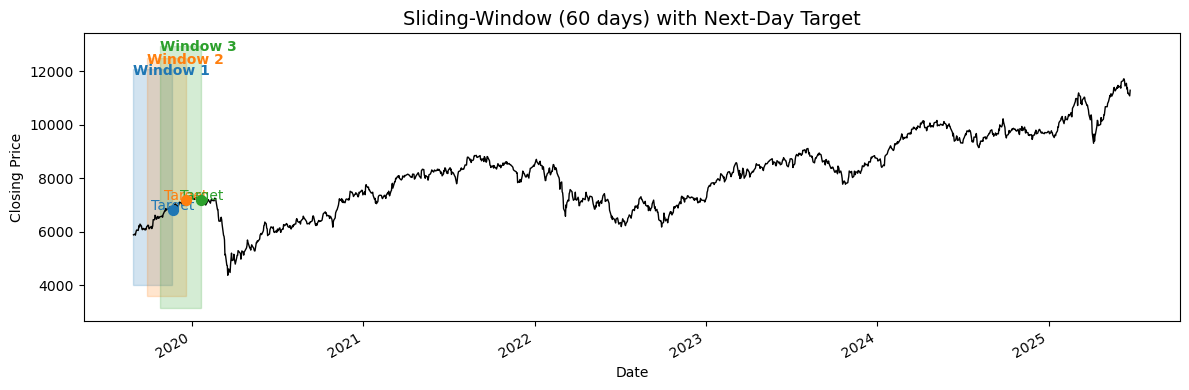

In [ ]:
from matplotlib.patches import Rectangle


df = pd.read_csv("/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/cleaned/Cleaned_IRELAND.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

series = df["Close"].values
dates  = df["Date"].values

window_size = 60  # lookback length
step        = 20  # how far apart to show successive windows


fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, series, lw=1, color="black")


for i, start in enumerate(range(0, 3*step, step)):
    end   = start + window_size - 1
    if end + 1 >= len(series): 
        break

    # draw shaded window
    ax.add_patch(Rectangle(
        (dates[start], ax.get_ylim()[0]),
        dates[end] - dates[start],
        ax.get_ylim()[1] - ax.get_ylim()[0],
        alpha=0.2,
        color=f"C{i}"
    ))
    # mark target point
    tgt_idx = end + 1
    ax.scatter(dates[tgt_idx], series[tgt_idx], color=f"C{i}", s=50, zorder=5)
    
    # annotate
    ax.text(dates[start], ax.get_ylim()[1]*0.95,
            f"Window {i+1}", color=f"C{i}", weight="bold")
    ax.text(dates[tgt_idx], series[tgt_idx]+0.5,
            "Target", ha="center", color=f"C{i}")


ax.set_title("Sliding-Window (60 days) with Next-Day Target", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
